## Introduction to Q-learning with OpenAI Gym
This is a step-by-step guide to using Q-learning in a simple OpenAI gym environment.

The notebook is based on https://github.com/gelanat/reinforcement-learning/blob/ba523383ef3e9de270eb1fd4d46b475d716a2274/Q-learning.ipynb

### Table of Contents

#### [Setup and Environment](#Setup_and_Environment)
- in this section, we download and examine the environment after importing all the necessary libraries;

#### [Q-learning](#Q-learning)
- in this section, we use Q-learning to solve the Taxi problem.


## Setup and Environment <a name='Setup_and_Environment'></a>

1. Install the necessary packages and libraries;
2. Set up the Taxi environment;
3. Determine the state and action space for our Q-table.

In [1]:
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output
from collections import defaultdict

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns


In [2]:
# Fixing seed for reproducibility
np.random.seed(0) 

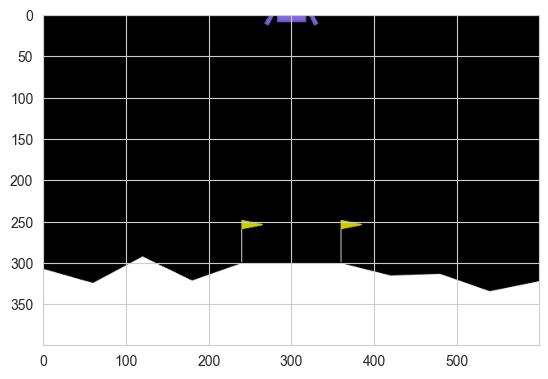

In [3]:
# Loading and rendering the gym environment
#env = gym.make("Taxi-v3", render_mode="human")
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

In [4]:
#Getting the state space
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
print("Sample Observation {}".format(env.observation_space.sample()))

Action Space Discrete(4)
State Space Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Sample Observation [ 0.9226974   0.29902676 -0.8137009   2.1754324   3.250715   -9.0207615
  0.21041356  0.9228903 ]


## Q-learning

1. initialize our Q-table given the state and action space in STEP 1;
    - choose the hyperparameters for training;
2. choose an action: explore or exploit in STEP 2;
3. perform the action and measure the reward in STEPs 3 & 4;
4. ^^
5. update the Q-table using the Bellman equation in STEP 5.
    - update the collected rewards
    - use decay to balance exploration and exploitation

In [22]:
#Setting the hyperparameters

max_epsilon = 1
min_epsilon = 0.01
decay = 0.01

train_episodes = 2000
test_episodes = 100          
max_steps = 100

alpha = 0.8
discount_factor = 0.7

n_bins = 8

In [34]:
class QLearner:
    def __init__(self, env, n_bins, alpha, discount_factor, max_epsilon, min_epsilon, decay, adaptive_mode=True):
        self.env = env
        self.n_bins = n_bins
        self.bins = []
        self.alpha = alpha
        self.adaptive_mode = adaptive_mode
        self.discount_factor = discount_factor
        self.epsilon = max_epsilon
        self.epsilon_max = max_epsilon
        self.epsilon_min = min_epsilon
        self.epsilon_decay = decay
        self.visited = defaultdict(int)

        for low, high in zip(self.env.observation_space.low, self.env.observation_space.high):
            if np.isinf(low) or np.isinf(high):
                low, high = -1, 1
            self.bins.append(np.linspace(low, high, self.n_bins-1))

        self.state_shape = tuple([self.n_bins] * self.env.observation_space.shape[0])
        self.action_shape = self.env.action_space.n
        self.Q = np.zeros(self.state_shape + (self.action_shape,))
        # print(self.Q)

    def discretize_state(self, obs):
        state = []
        for i in range(len(obs)):
            bin_idx = np.digitize(obs[i], self.bins[i])
            state.append(min(bin_idx, self.n_bins - 1))
        return tuple(state)

    def choose_action(self, state):
        rand_i = random.uniform(0, 1)
        if rand_i > self.epsilon:
            action = np.argmax(self.Q[state])
        else:
            action = self.env.action_space.sample()
        return action

    def update_Q(self, state, new_state, action, reward):
        self.visited[state] += 1
        if self.adaptive_mode:
            self.alpha = 60 / (59 + self.visited[state])

        self.Q[state][action] += self.alpha * (reward + self.discount_factor * np.max(self.Q[new_state]) - self.Q[state][action])

    # def decay_epsilon(self):
    #     self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

agent = QLearner(env, n_bins, alpha, discount_factor, max_epsilon, min_epsilon, decay, adaptive_mode=False)

In [35]:
#Training the agent

def train_agent(max_steps, diff):
    training_rewards = []
    epsilons = []
    episode = 0

    while agent.epsilon - agent.epsilon_min >= diff:
        episode += 1

        state, info = agent.env.reset()
        state = agent.discretize_state(state)
        total_training_rewards = 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = agent.env.step(action)
            new_state = agent.discretize_state(new_state)

            agent.update_Q(state, new_state, action, reward)
            total_training_rewards += reward
            state = new_state

            if terminated or truncated:
                # print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break

        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min)*np.exp(-agent.epsilon_decay*episode)

        training_rewards.append(total_training_rewards)
        epsilons.append(agent.epsilon)

        print ("Total reward for episode {}: {}, Epsilon: {}".format(episode, sum(training_rewards)/episode, agent.epsilon))

    print("Training score over time: " + str(sum(training_rewards)/episode))

    return training_rewards, epsilons, episode

training_rewards, epsilons, train_episodes = train_agent(max_steps, diff=0.01)


Total reward for episode 1: 1.1948307179862336, Epsilon: 0.9901493354116764
Total reward for episode 2: -129.39838473726388, Epsilon: 0.9803966865736877
Total reward for episode 3: -111.55352478042177, Epsilon: 0.970741078213023
Total reward for episode 4: -101.55003834592051, Epsilon: 0.9611815447608
Total reward for episode 5: -117.7370387438634, Epsilon: 0.9517171302557069
Total reward for episode 6: -104.99977620933275, Epsilon: 0.9423468882484062
Total reward for episode 7: -138.47990420607562, Epsilon: 0.9330698817068888
Total reward for episode 8: -139.57045136836877, Epsilon: 0.9238851829227694
Total reward for episode 9: -146.12811681118228, Epsilon: 0.9147918734185159
Total reward for episode 10: -151.29557129727678, Epsilon: 0.9057890438555999
Total reward for episode 11: -152.6021165120301, Epsilon: 0.896875793943563
Total reward for episode 12: -147.03092542567532, Epsilon: 0.888051232349986
Total reward for episode 13: -137.79724577700938, Epsilon: 0.8793144766113556
Tota

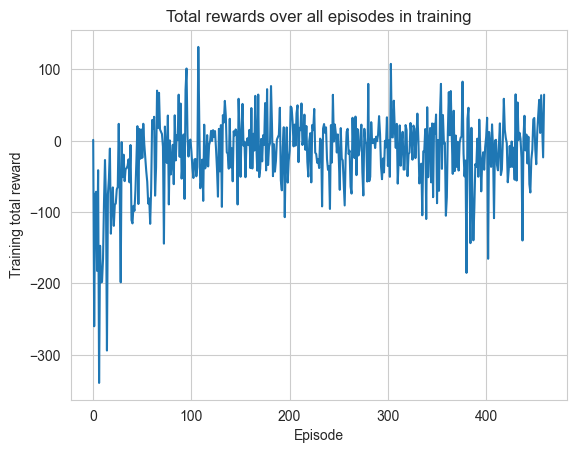

In [36]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

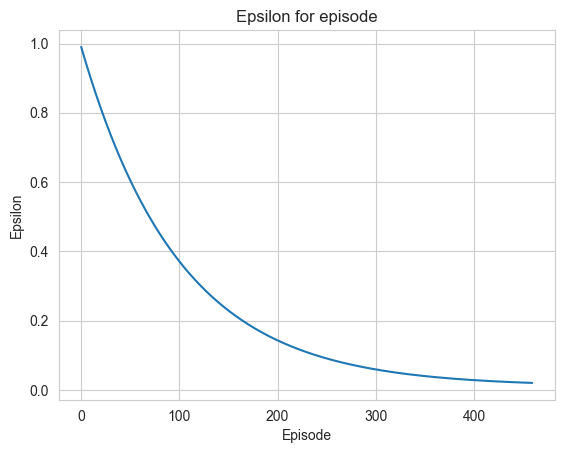

In [37]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

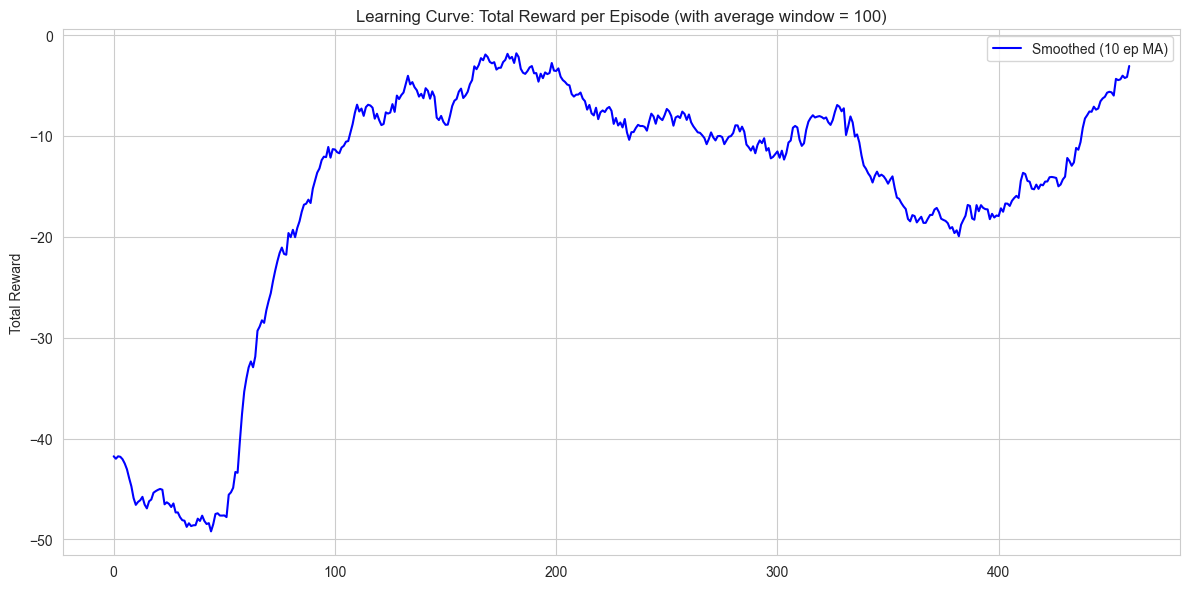

In [38]:
#Visualizing results and total reward over all episodes with moving_average
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

window_size = 100

plt.figure(figsize=(12, 6))
plt.plot(moving_average(training_rewards, window_size=window_size), color='blue', label='Smoothed (10 ep MA)')
plt.title("Learning Curve: Total Reward per Episode (with average window = {})".format(window_size))
plt.ylabel("Total Reward")
plt.legend()

plt.tight_layout()
plt.show()

step = 0


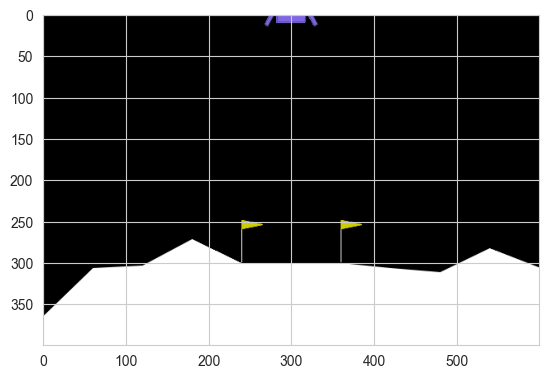

reward: -2.0090506973812965
step = 1


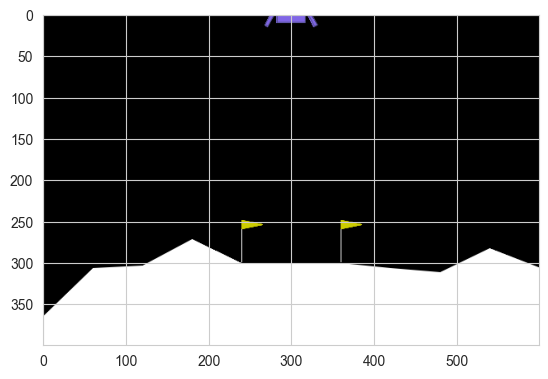

reward: -0.0040734264128047815
step = 2


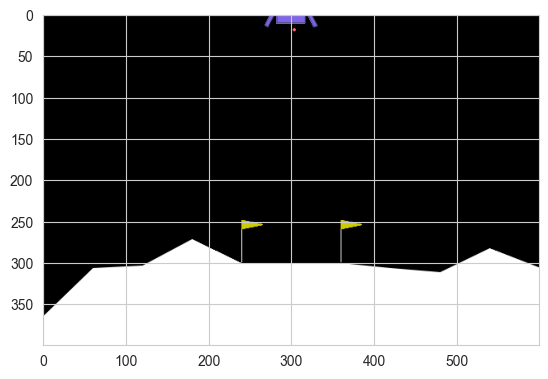

reward: 0.7650522158725266
step = 3


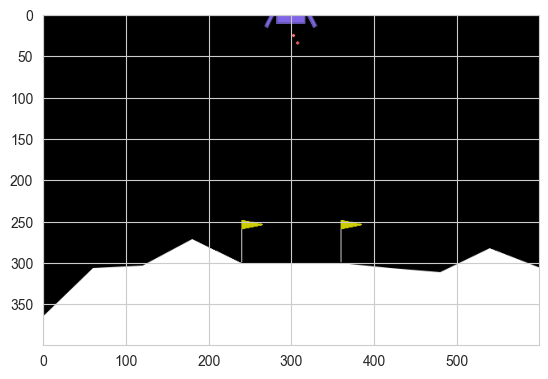

reward: 0.6148032627509223
step = 4


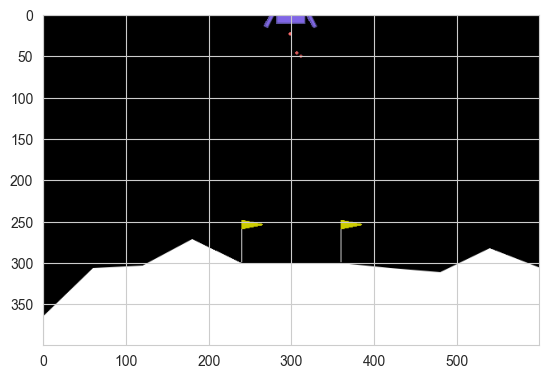

reward: 2.9720985091998218
step = 5


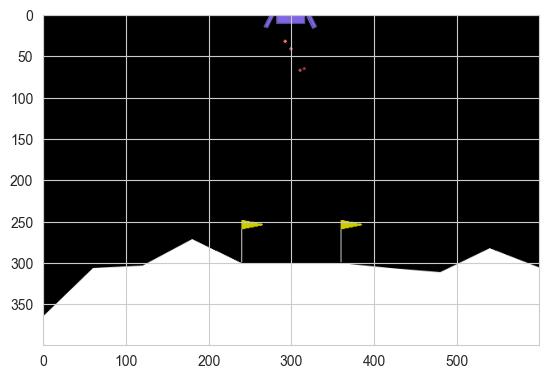

reward: 2.1772626692747794
step = 6


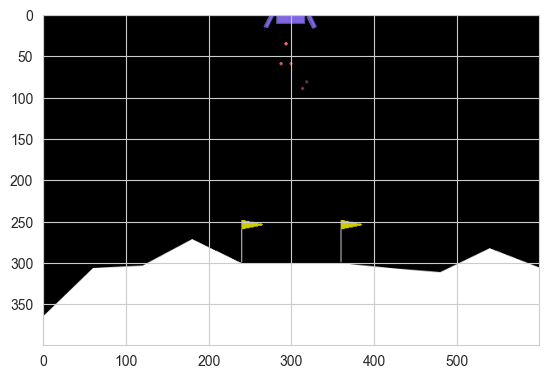

reward: -1.1207099693519353
step = 7


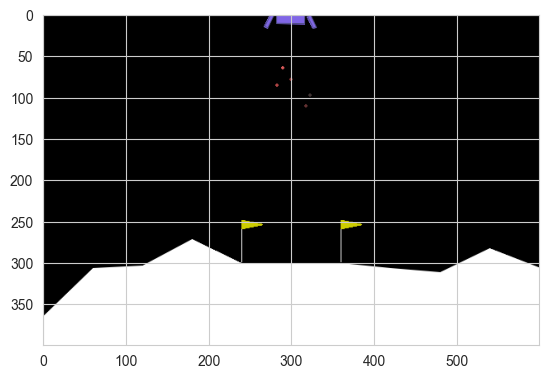

reward: 1.5073675895041674
step = 8


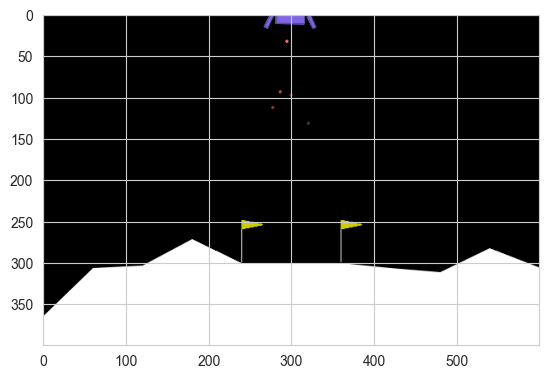

reward: -1.1356079996486699
step = 9


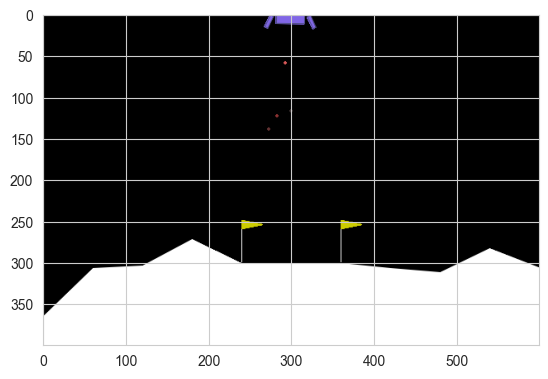

reward: -1.3377723062862856
step = 10


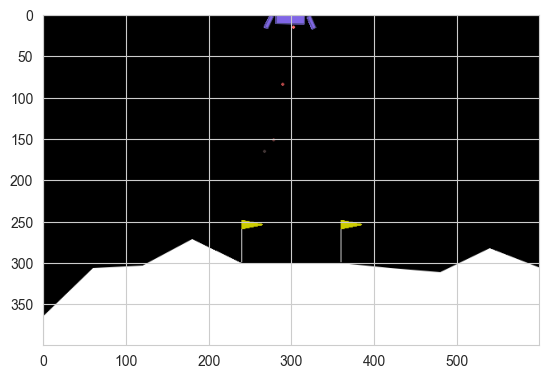

reward: -0.8883144143915616
step = 11


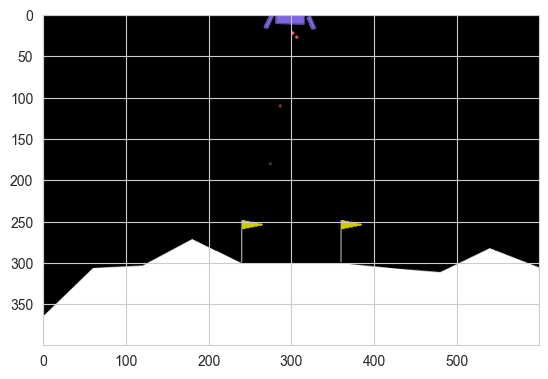

reward: 0.7623992996991944
step = 12


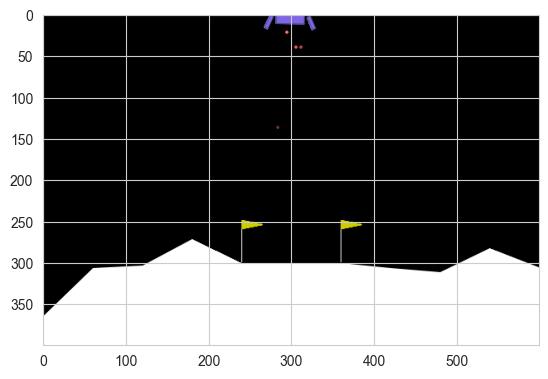

reward: -2.327153268951224
step = 13


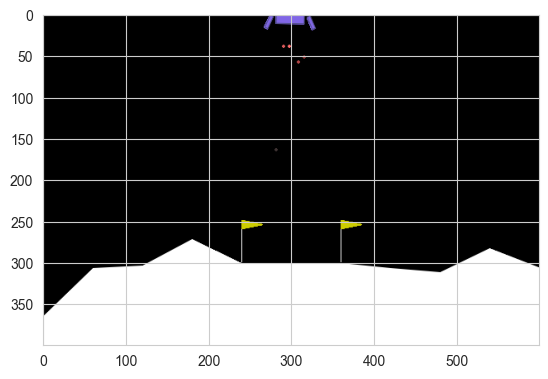

reward: 1.5331790545644424
step = 14


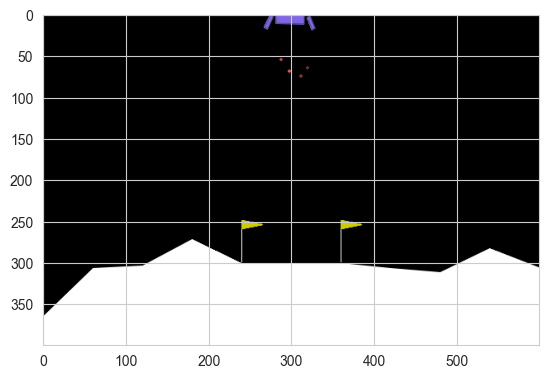

reward: -0.43053696443800504
step = 15


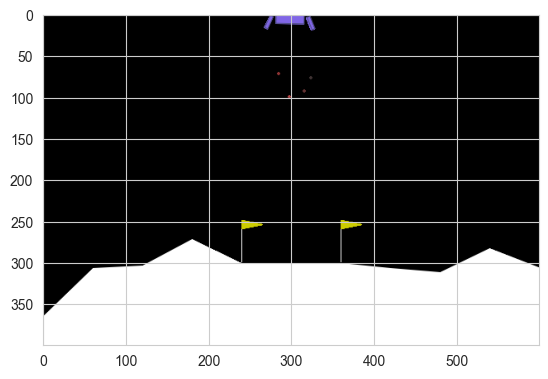

reward: -1.222094280572253
step = 16


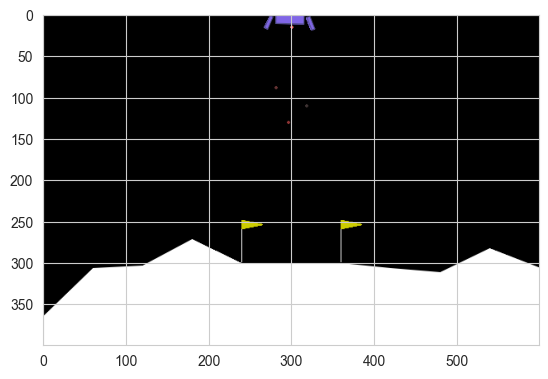

reward: 0.4439124605655252
step = 17


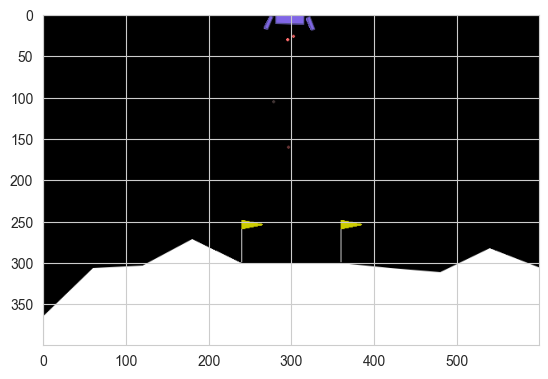

reward: -0.7619921150731557
step = 18


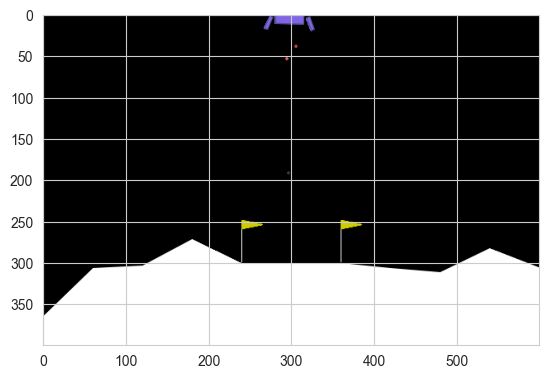

reward: 0.6635113364015524
step = 19


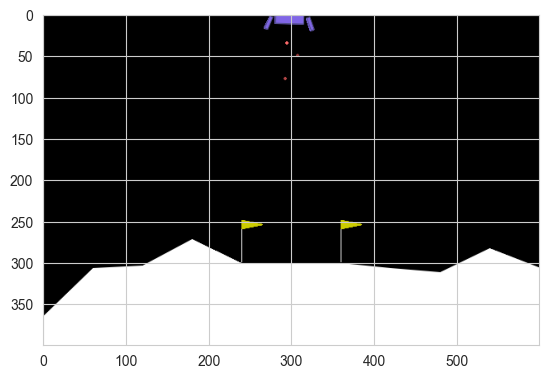

reward: -0.3398548534693475
step = 20


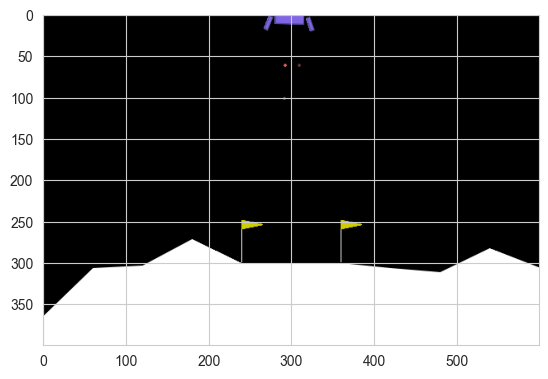

reward: -1.4133008902875475
step = 21


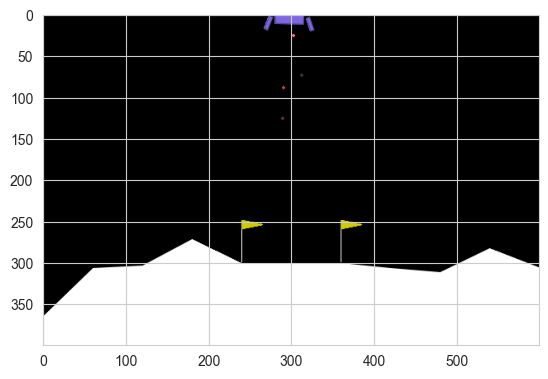

reward: -1.0156896770205037
step = 22


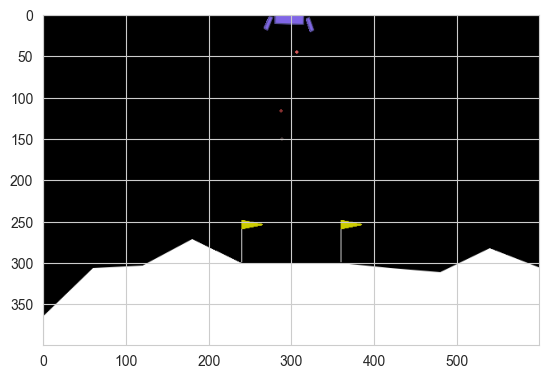

reward: 1.9246275279790097
step = 23


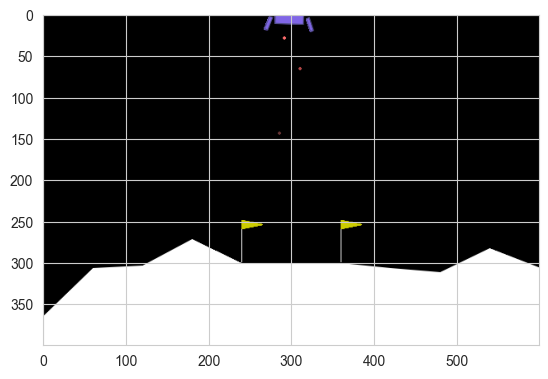

reward: 0.8576966799487422
step = 24


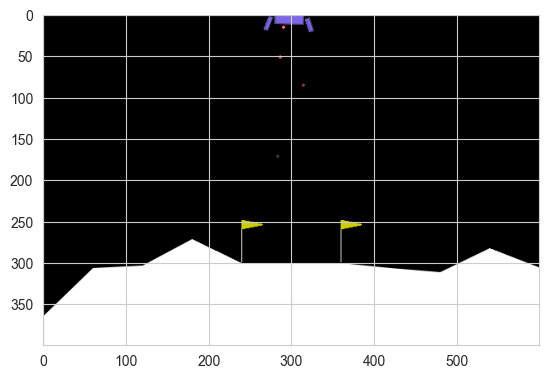

reward: -1.7431042792894005
step = 25


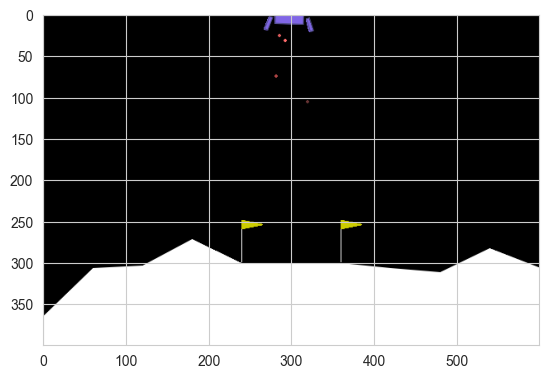

reward: 0.9157723526506913
step = 26


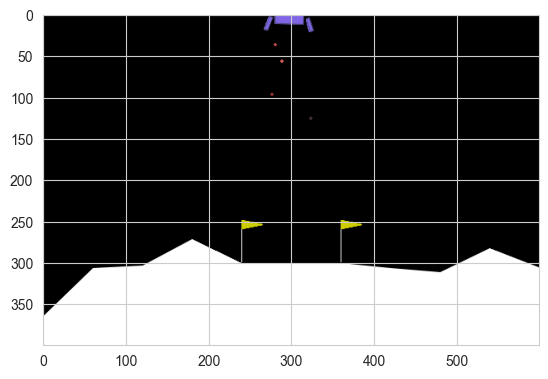

reward: -1.9470193990034363
step = 27


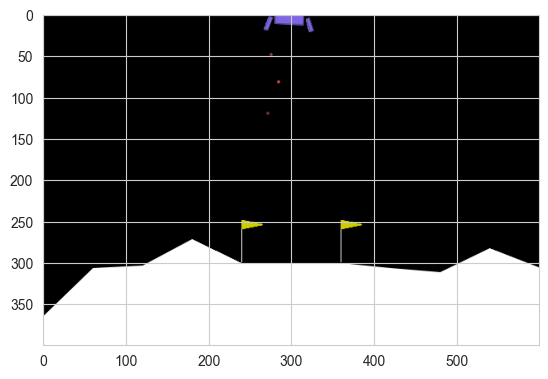

reward: 1.5587076916068099
step = 28


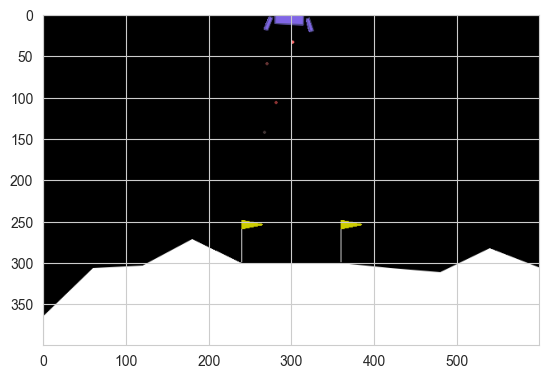

reward: -3.0139935284027386
step = 29


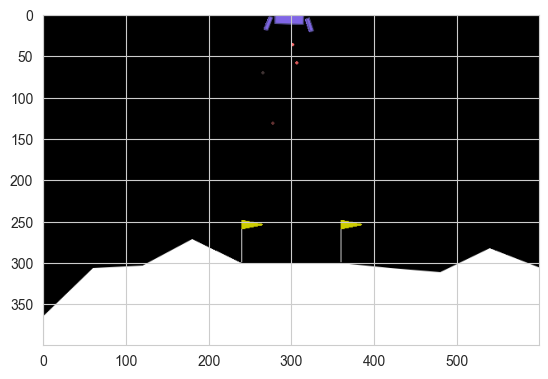

reward: 1.4003616069252587
step = 30


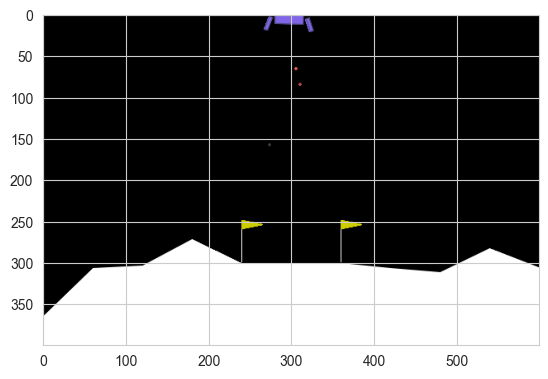

reward: -0.6309623184409645
step = 31


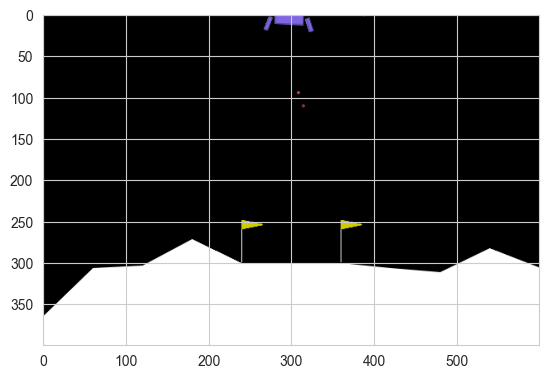

reward: 1.6790894799922966
step = 32


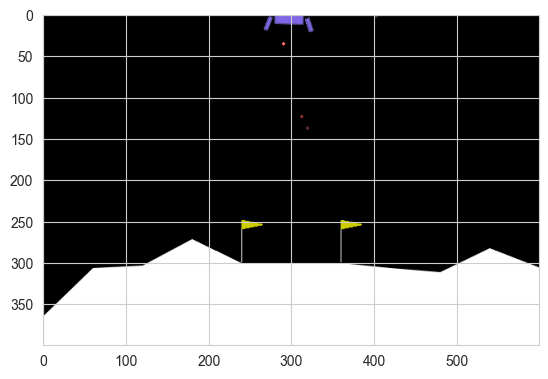

reward: -0.06861091512539019
step = 33


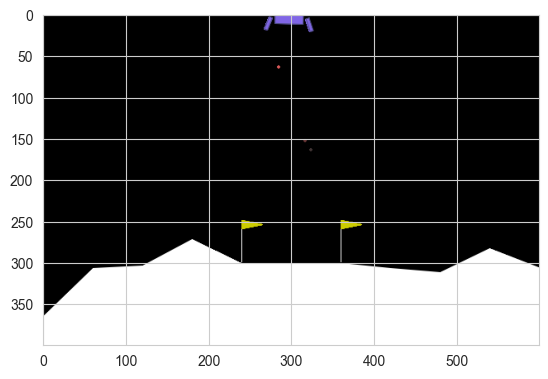

reward: -1.1896018362090672
step = 34


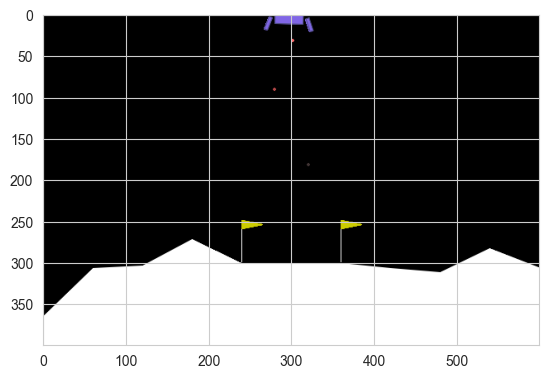

reward: -0.0007849118962326429
step = 35


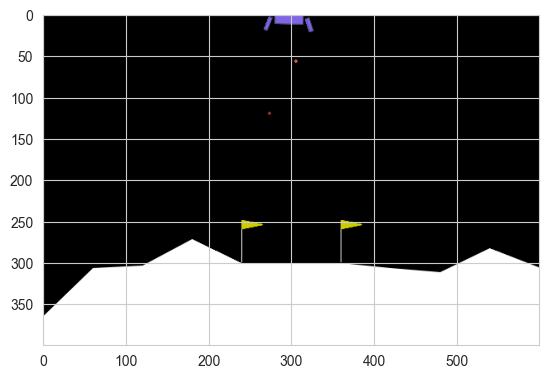

reward: -1.6381635589589962
step = 36


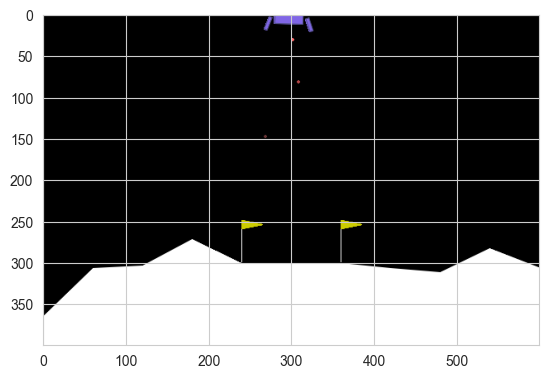

reward: -0.20807462277190325
step = 37


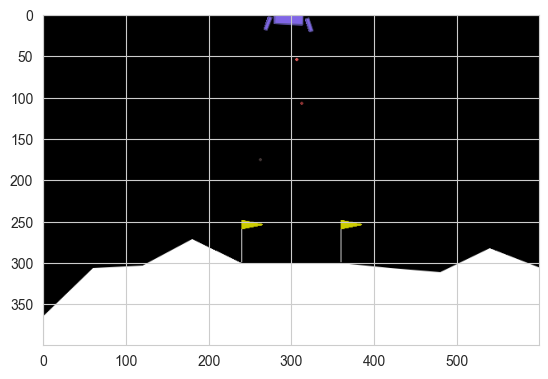

reward: 0.022061629882881573
step = 38


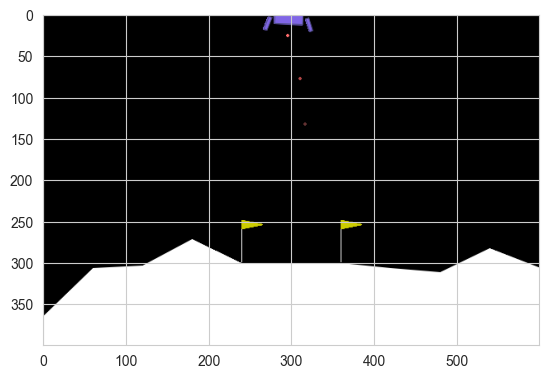

reward: -1.3324975103174268
step = 39


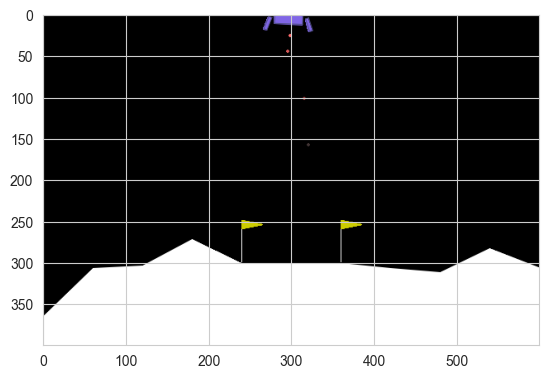

reward: 0.0018565275753417154
step = 40


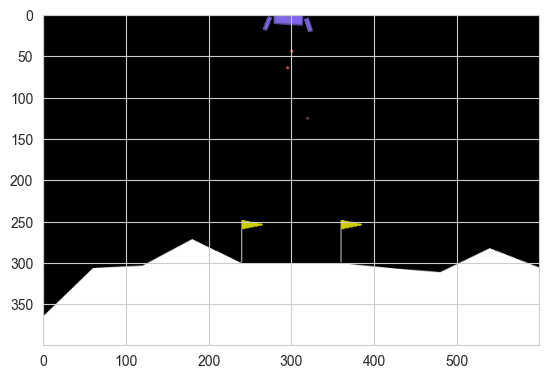

reward: -2.38758176081281
step = 41


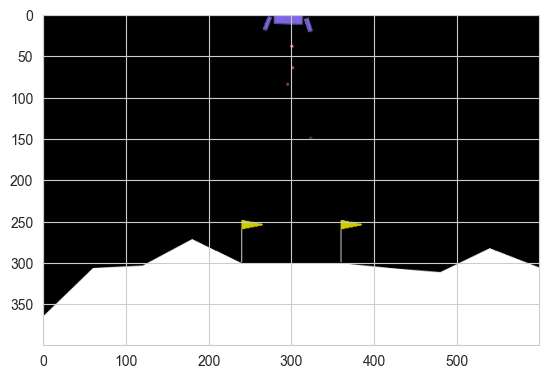

reward: 0.4945043222306822
step = 42


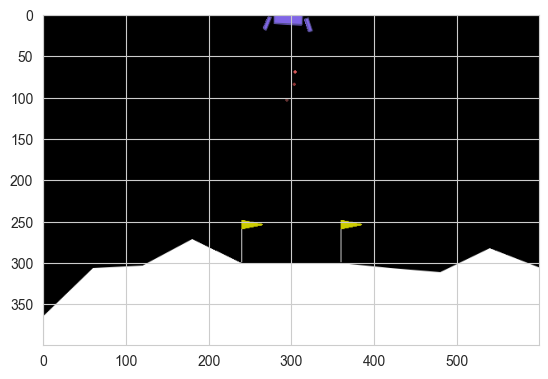

reward: -0.6687547812075536
step = 43


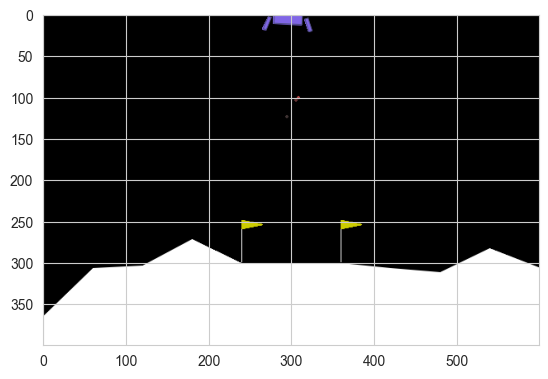

reward: -0.07730540635349142
step = 44


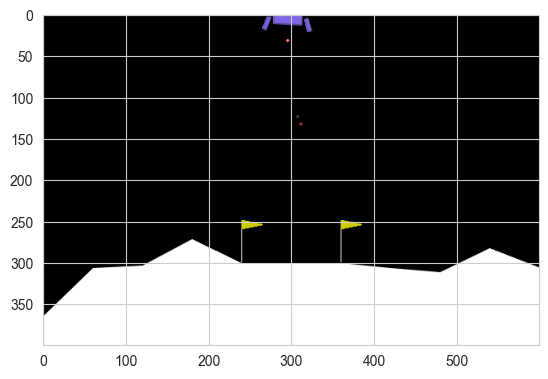

reward: -0.6615799388771677
step = 45


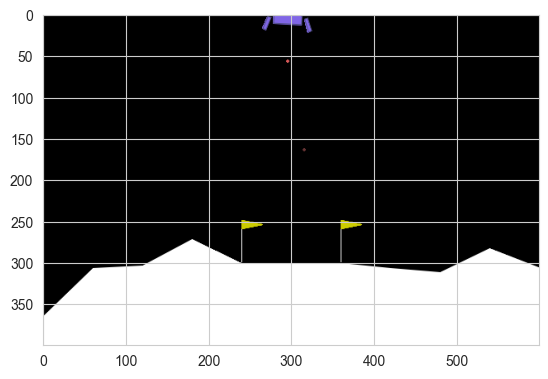

reward: -0.6593729262920249
step = 46


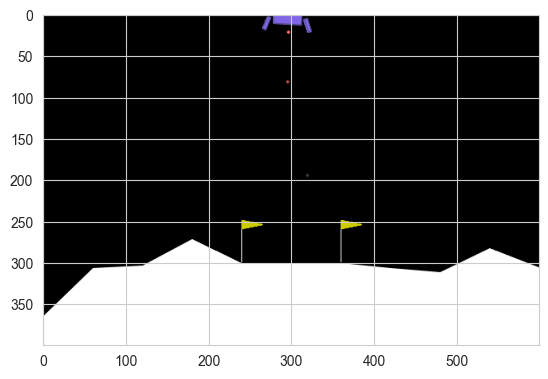

reward: 0.33345687425703546
step = 47


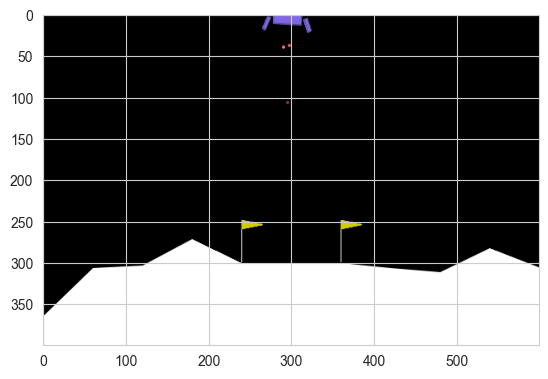

reward: 0.3697582629730789
step = 48


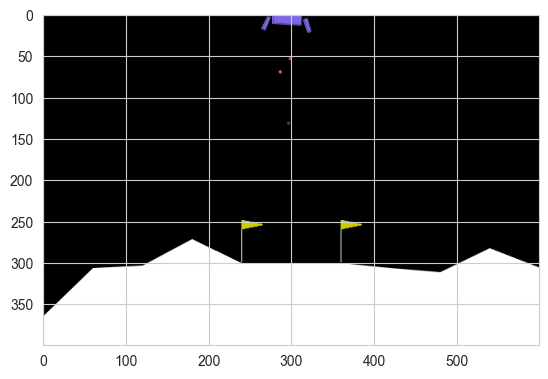

reward: -1.485034499940798
step = 49


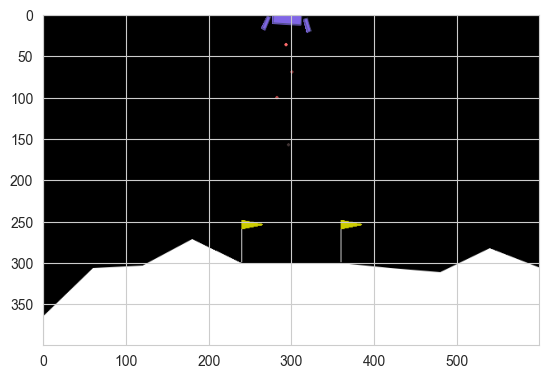

reward: 0.7763271836825822
step = 50


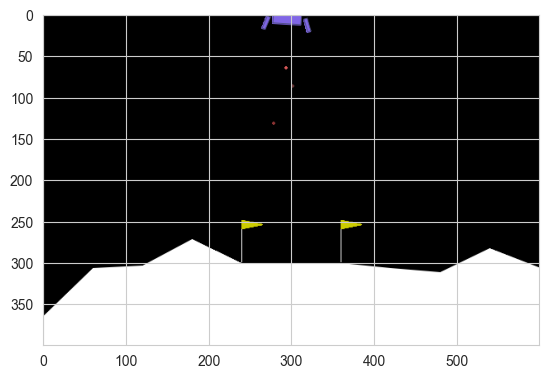

reward: -0.6022495188971959
step = 51


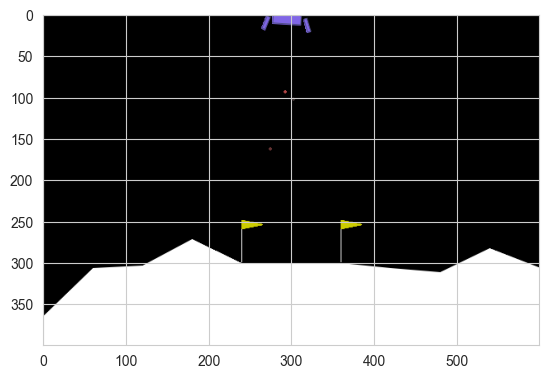

reward: 1.4800296277606548
step = 52


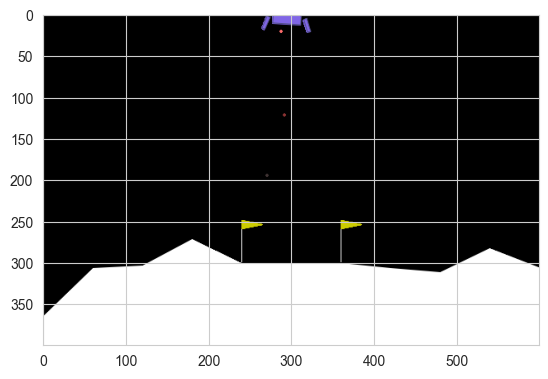

reward: 1.4296460677255538
step = 53


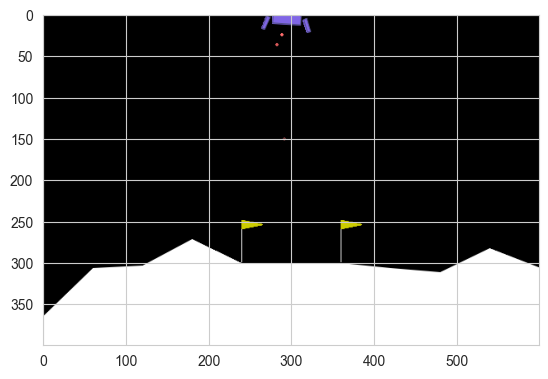

reward: -1.681333845696173
step = 54


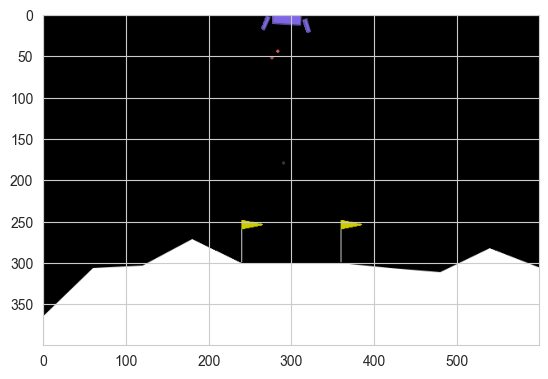

reward: -0.4950007898676347
step = 55


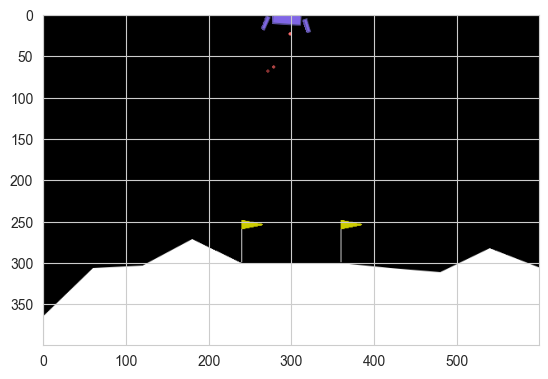

reward: 0.0352825145343843
step = 56


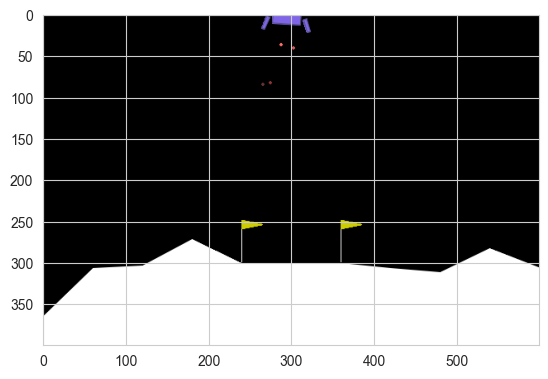

reward: 1.3815694374864904
step = 57


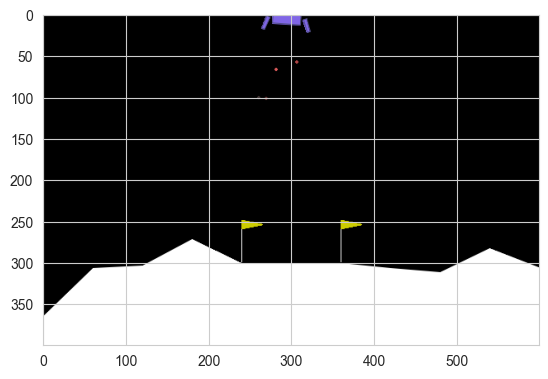

reward: -2.5101818010894474
step = 58


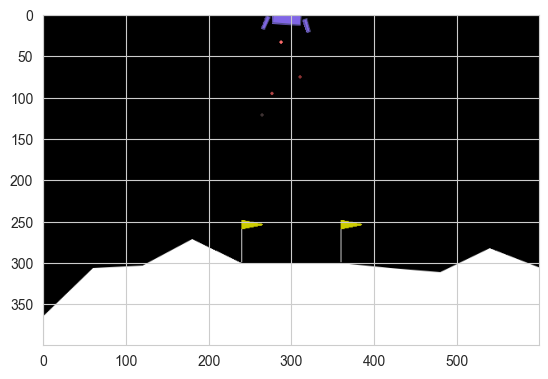

reward: 1.581904684792704
step = 59


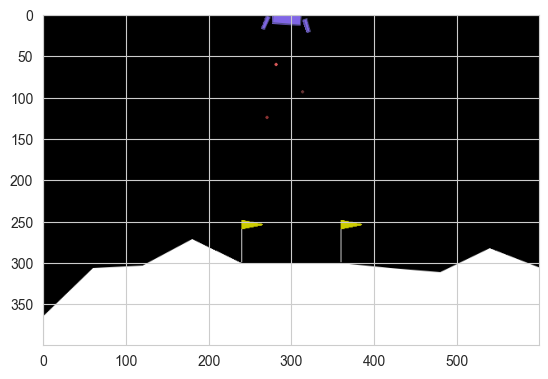

reward: -1.340285245530963
step = 60


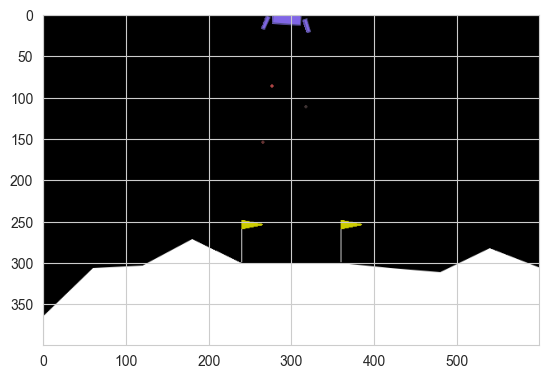

reward: -2.289917623218854
step = 61


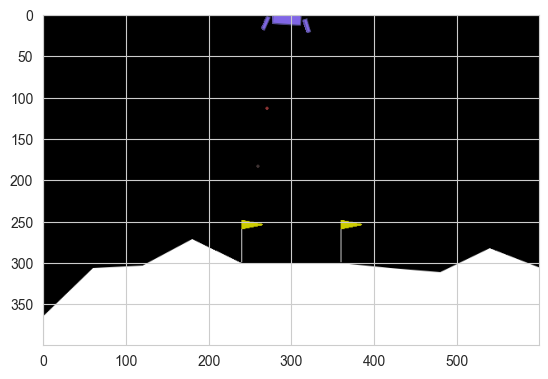

reward: 2.802894261203659
step = 62


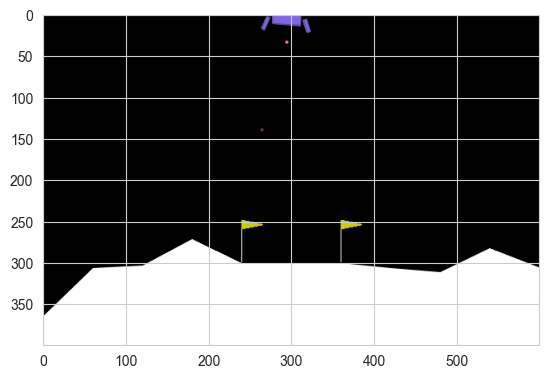

reward: -0.2531052591589457
step = 63


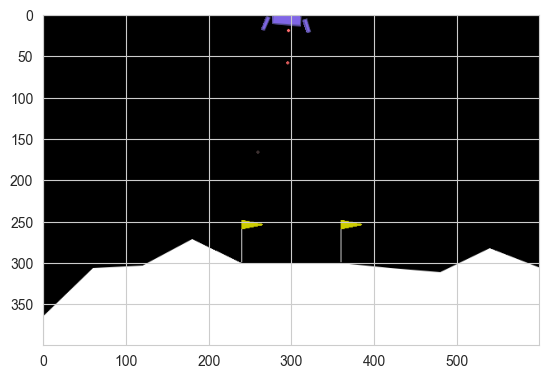

reward: -0.13399165288707876
step = 64


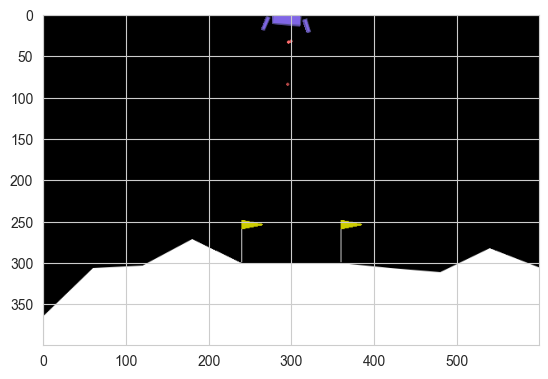

reward: -0.22314696529886646
step = 65


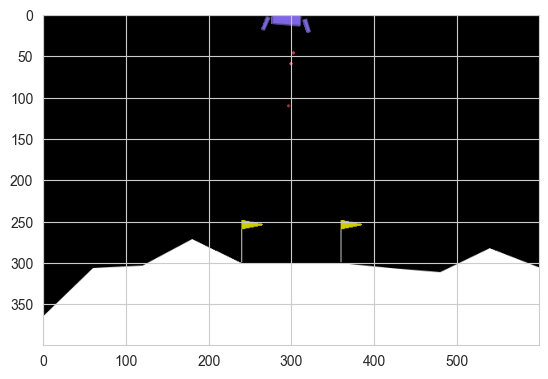

reward: 0.5494729011906088
step = 66


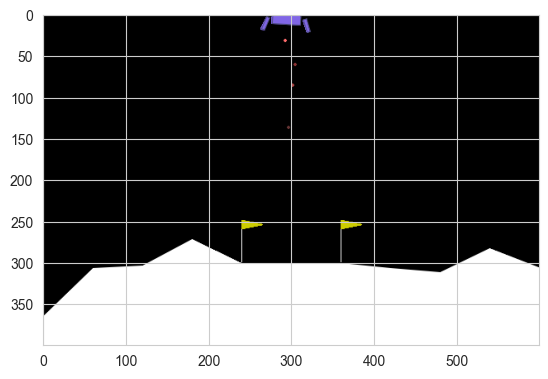

reward: -0.30155237513662314
step = 67


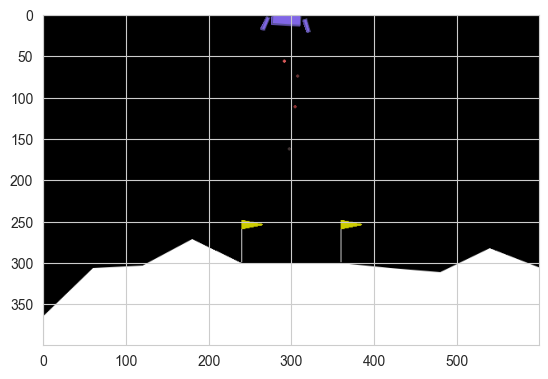

reward: 1.9385539806828376
step = 68


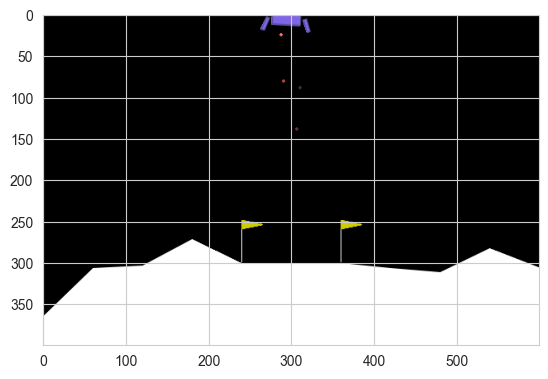

reward: -0.9032833967415457
step = 69


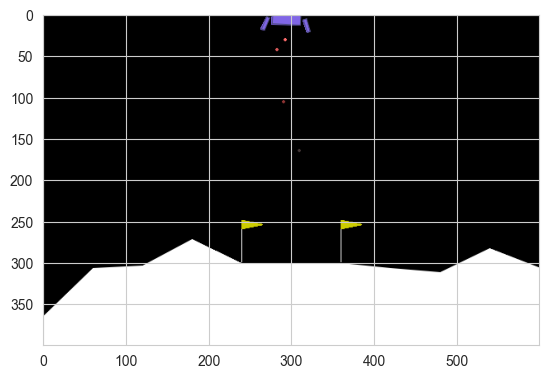

reward: 0.9677064848002033
step = 70


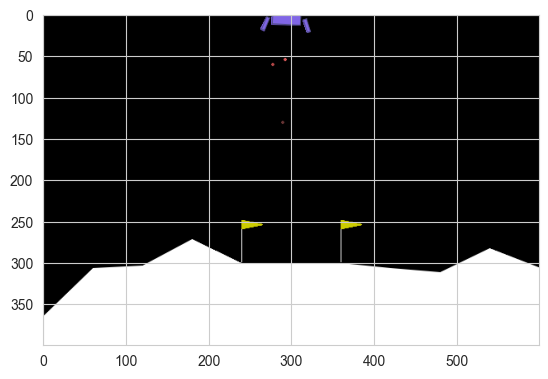

reward: -1.6197298691474942
step = 71


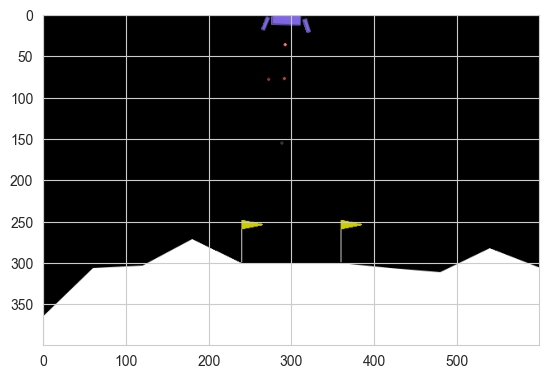

reward: 2.4457222746355
step = 72


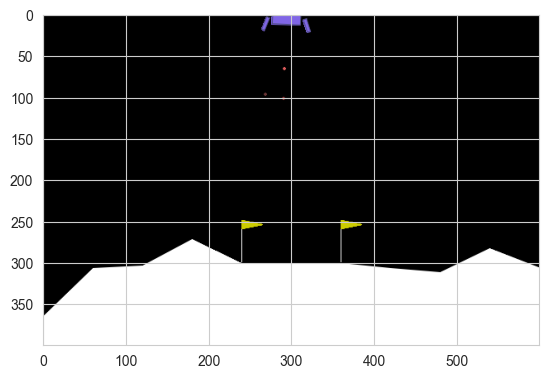

reward: -2.2036216467167717
step = 73


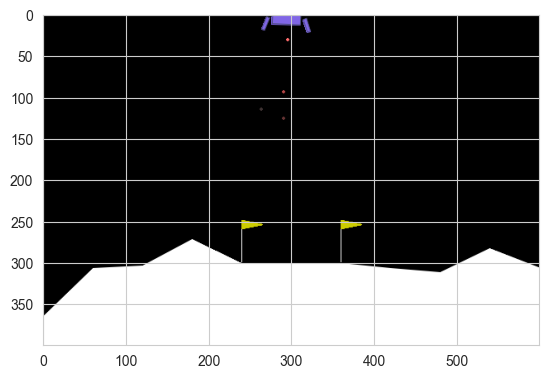

reward: 1.6419091365085592
step = 74


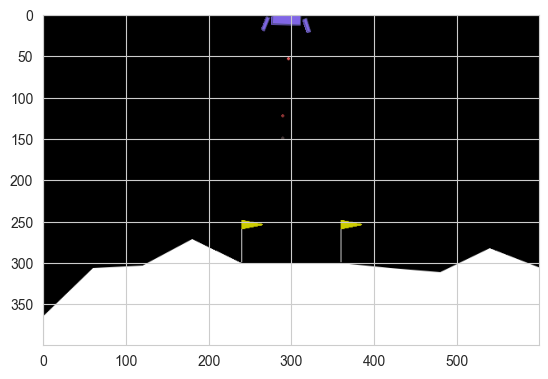

reward: -2.6055382284070445
step = 75


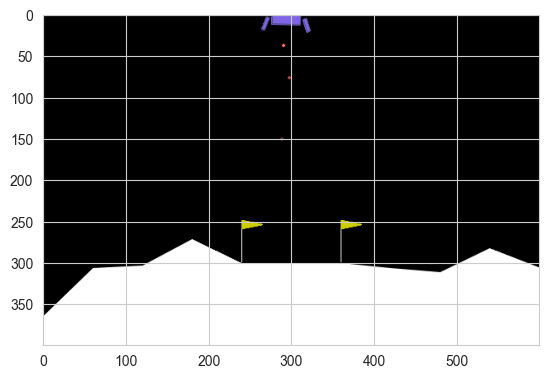

reward: 2.8330829895477905
step = 76


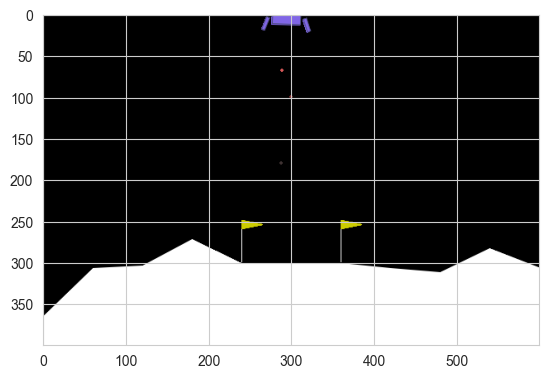

reward: -1.1100860821447327
step = 77


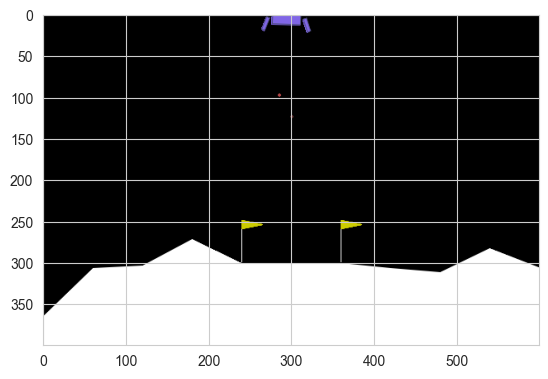

reward: 1.7057580424253558
step = 78


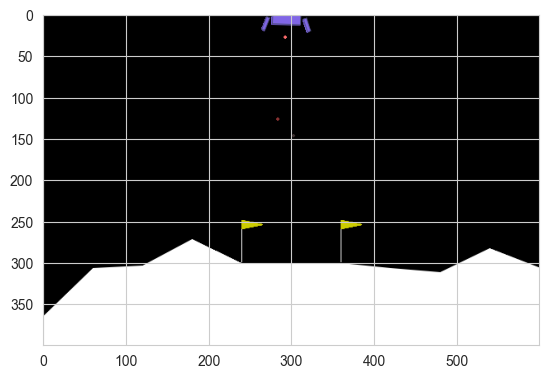

reward: -2.3164001432548944
step = 79


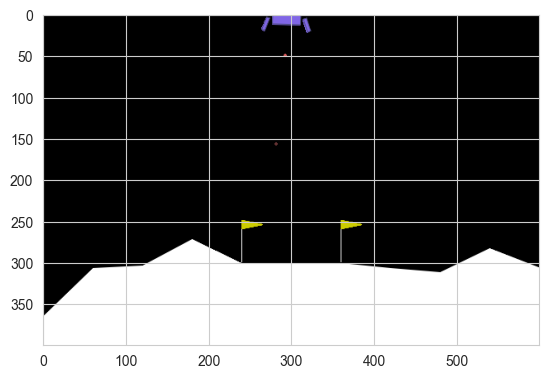

reward: 0.9924371677434862
step = 80


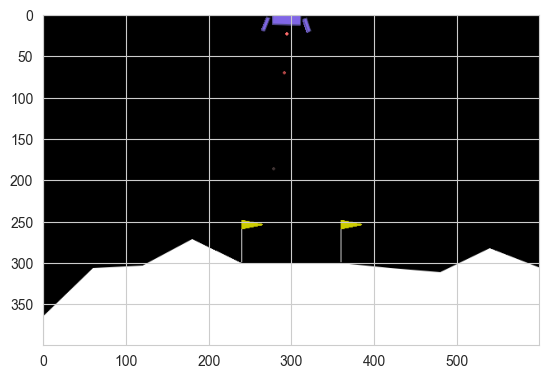

reward: -0.15232382793552118
step = 81


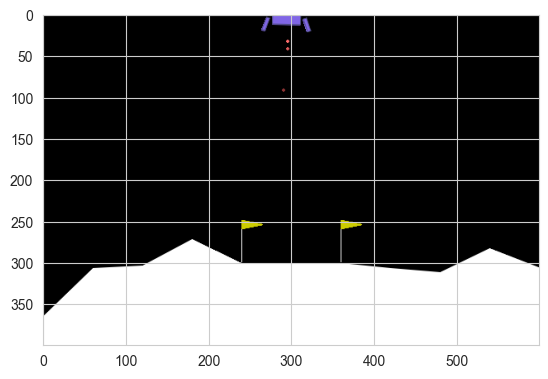

reward: 0.2290523437179388
step = 82


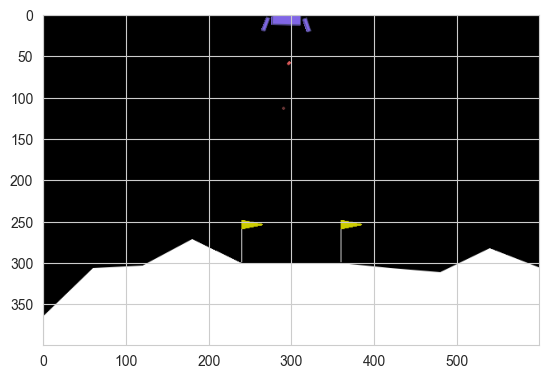

reward: -0.1488777399389562
step = 83


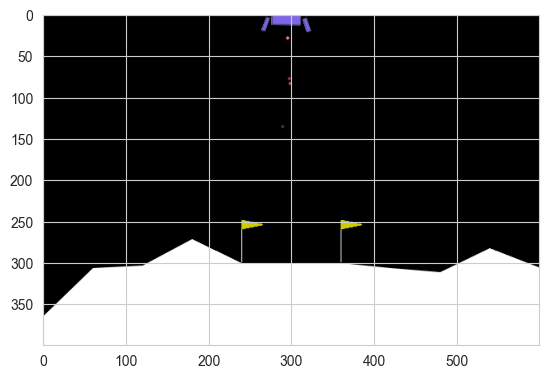

reward: -0.44927985532626735
step = 84


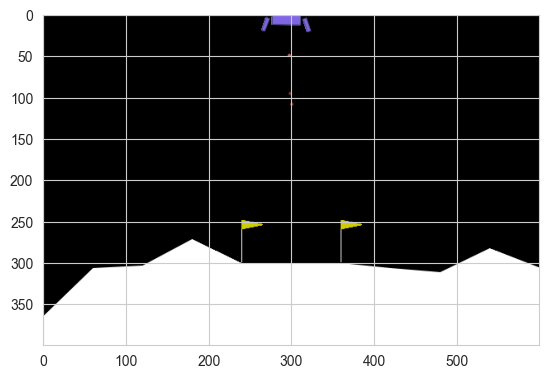

reward: 1.337576213152954
step = 85


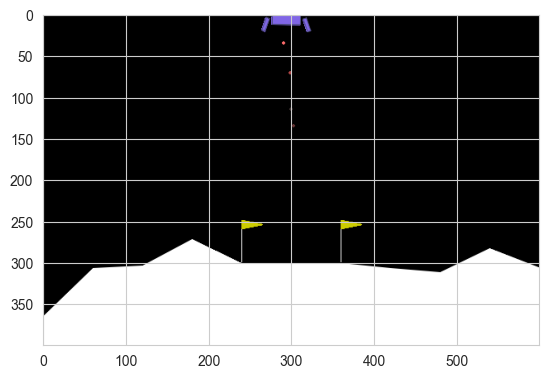

reward: -0.24538897307493812
step = 86


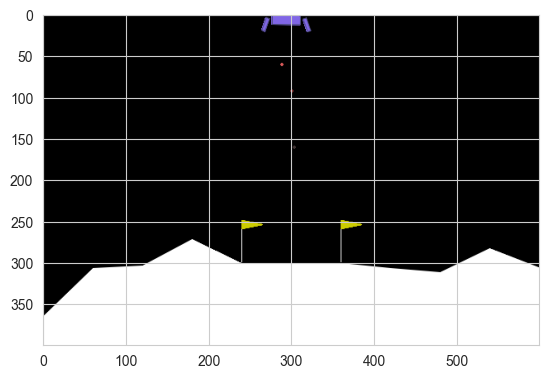

reward: 1.3207127462103017
step = 87


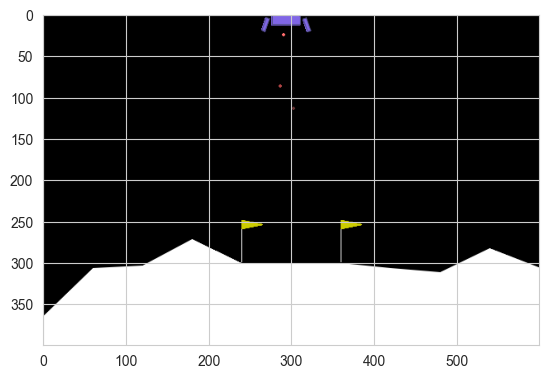

reward: -2.11812057817055
step = 88


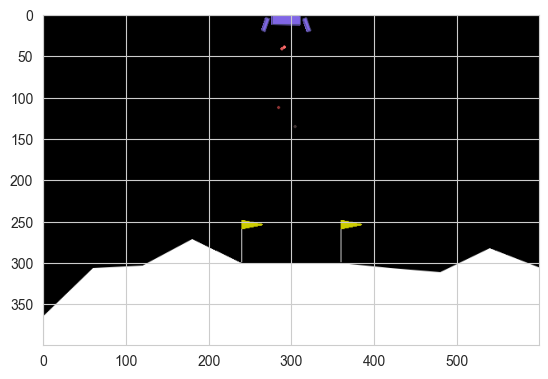

reward: 2.5744875587699596
step = 89


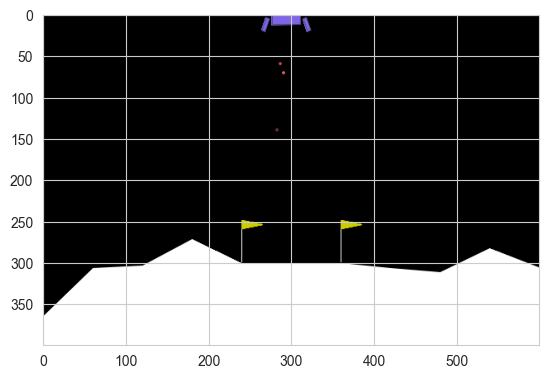

reward: -1.2085456207711036
step = 90


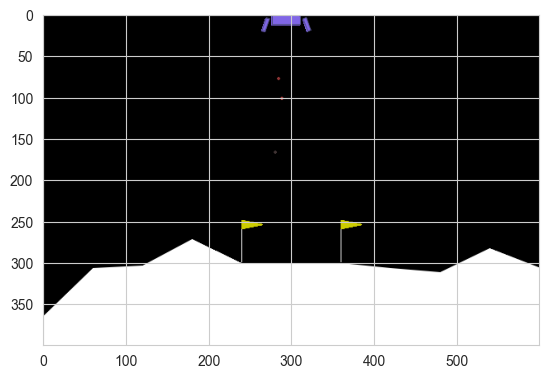

reward: -0.1510700107411253
step = 91


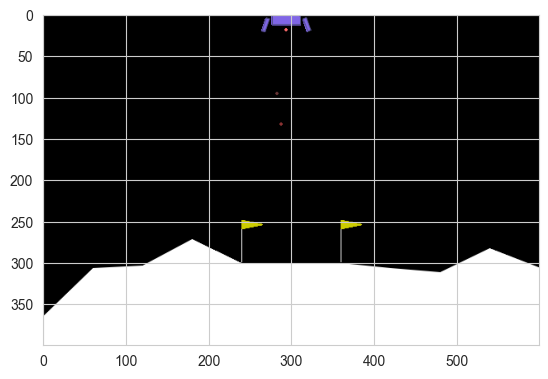

reward: -0.800869137029099
step = 92


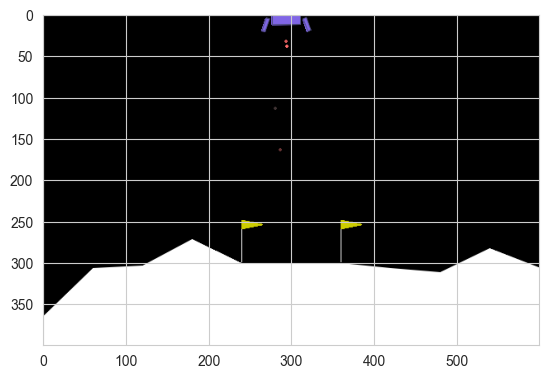

reward: 1.1272258015307568
step = 93


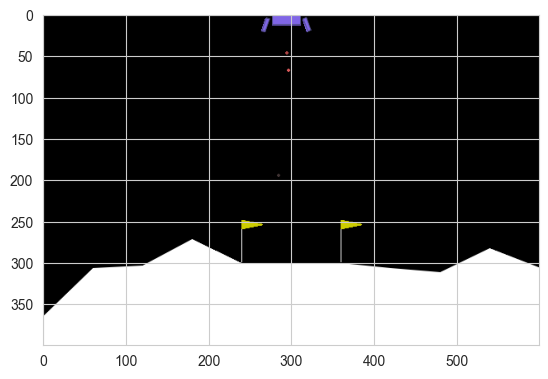

reward: -0.22325505743991697
step = 94


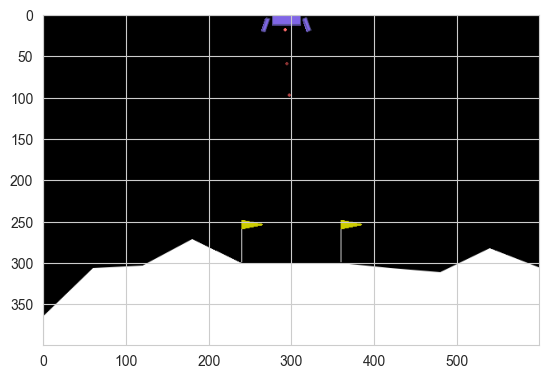

reward: -0.7579143558370902
step = 95


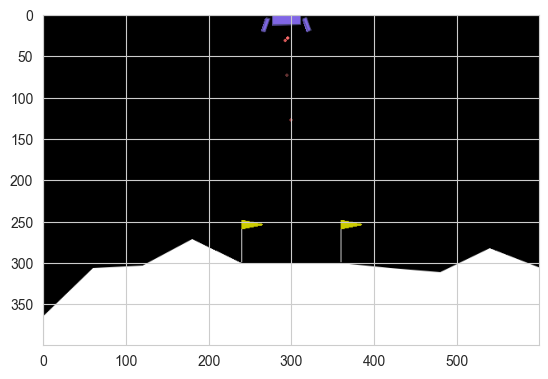

reward: -0.08177691684801289
step = 96


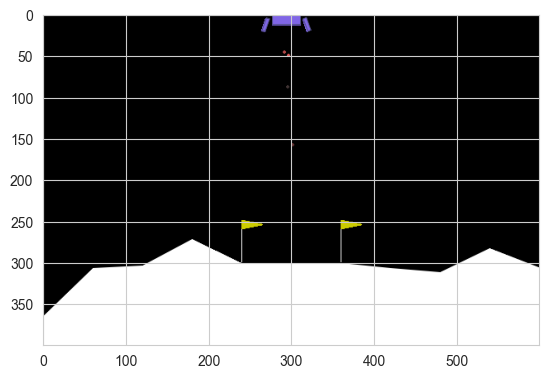

reward: -2.280156632498715
step = 97


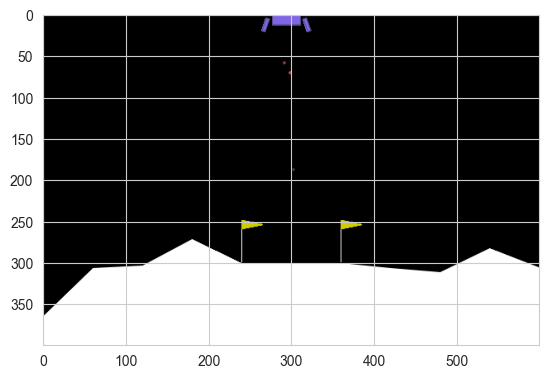

reward: 1.9707099356210847
step = 98


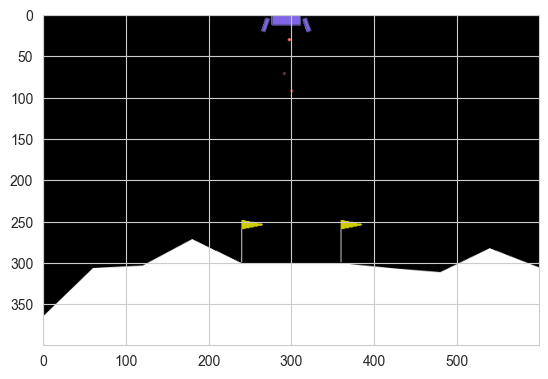

reward: 0.7238845621516077
step = 99


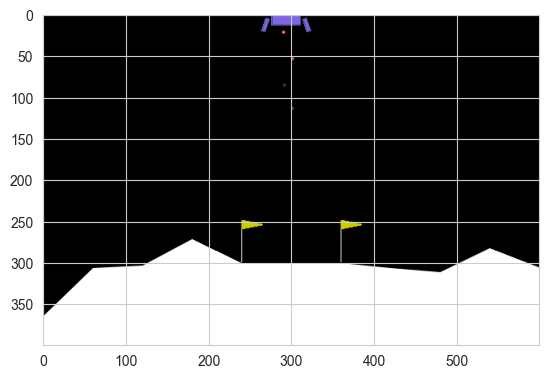

reward: -0.3350965551981517


In [130]:
import time

def showcase_agent():
    state, info = env.reset()
    state = agent.discretize_state(state)
    total_rewards = 0.0
    agent.epsilon = 0.0 # we don't want random actions here
    for step in range(100):
        print(f"step = {step}")
        plt.imshow(env.render())
        plt.show()
        time.sleep(0.1)
        action = agent.choose_action(state)
        new_state, reward, terminated, truncated, info = env.step(action)
        new_state = agent.discretize_state(new_state)
        print(f"reward: {reward}")
        total_rewards += reward
        state = new_state

        #Ending the episode
        if terminated or truncated:
            print("game finished!")
            print(f"Total reward: {total_rewards}")
            break
    env.close()

showcase_agent()